## GPS Trajectory Map-matching Demo

由于网上的公开轨迹数据集往往是GPS数据集，而有时项目中需要使用路网映射后的数据。因此本文档描述了一种基于HMM模型的，对GPS轨迹进行路网映射算法的python实现demo，并提供了可视化工具。<br/>
所依赖的第三方库主要包括:<br/>
transbigdata          --轨迹预处理和可视化<br/>
leuvenmapmatching     --地图匹配算法包<br/>
geopandas             --处理空间数据的库，操作方式类似pandas<br/>

## 加载数据集

In [1]:
# 空间数据预处理包
import transbigdata as tbd
import pandas as pd
# 地图匹配包
from leuvenmapmatching.matcher.distance import DistanceMatcher
from leuvenmapmatching.map.inmem import InMemMap
# from leuvenmapmatching import visualization as mmviz
import geopandas
import sys
sys.path.append('..')
from utils.utils import *
# 忽略普通告警
import warnings
warnings.filterwarnings("ignore")
import osmnx as ox
from tqdm import tqdm
import numpy as np
from tqdm import trange
import osmnx as ox
import geopandas as gpd
import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm

dataset_dir = "C:/tyb_file/tyb_tasks/pathlet/datasets/"


In [2]:
# #读取数据 ！深圳 ！

data_raw = pd.read_csv(dataset_dir+'TaxiData.csv',header = None)
data_raw.columns = ['VehicleNum','Time','Lng','Lat','OpenStatus','Speed']
print(data_raw.head(1))
print("len(data_raw):",len(data_raw))
bounds_shenzhen = [113.7516, 22.4000,114.6229,22.855] # 深圳范围
# 过滤步骤1 - 过滤掉不在深圳的数据点
data = data_raw[data_raw["Lng"]>bounds_shenzhen[0]]
data = data[data["Lng"]<bounds_shenzhen[2]]
data = data[data["Lat"]>bounds_shenzhen[1]]
data = data[data["Lat"]<bounds_shenzhen[3]]
print("len(data):",len(data))
width=bounds_shenzhen[2]-bounds_shenzhen[0]
height=bounds_shenzhen[3]-bounds_shenzhen[1]
print(width,height)
bounds = bounds_shenzhen

   VehicleNum      Time         Lng        Lat  OpenStatus  Speed
0       22223  21:09:38  114.138535  22.609266           1     19
len(data_raw): 46927855
len(data): 46835649
0.8713000000000051 0.45500000000000185


In [3]:
data.head()

,VehicleNum,Time,Lng,Lat,OpenStatus,Speed
0,22223,21:09:38,114.138535,22.609266,1,19
1,22223,11:14:18,114.137871,22.575317,0,0
2,22223,01:18:28,114.137131,22.575983,0,0
3,22223,13:11:42,114.136269,22.545851,1,18
4,22223,02:05:47,114.135948,22.578917,0,29


tbd可视化总体data 以及某一个trip随时间动向

In [4]:
# tbd.visualization_trip(data,col = ['Lng', 'Lat', 'VehicleNum', 'Time'])
tbd.visualization_data(data,col = ['Lng','Lat'],accuracy=300)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'ytak0zp', 'type': …

获得od数据并且识别载客轨迹 

In [5]:
# shenzhen or lianjing beijing
#从GPS数据提取OD与路径GPS
oddata_raw = tbd.taxigps_to_od(data,col = ['VehicleNum','Time','Lng','Lat','OpenStatus'])

data_deliver_raw,data_idle = tbd.taxigps_traj_point(data,oddata_raw,col=['VehicleNum', 'Time', 'Lng', 'Lat', 'OpenStatus'])

# 过滤步骤2 过滤轨迹点过少的轨迹 至少需要9个gps数据点
before_cnt = pd.DataFrame(data_deliver_raw["ID"].value_counts() )
before_cnt = before_cnt.reset_index()
before_cnt.columns=['ID','cnt1']
res = before_cnt[before_cnt['cnt1']>8]
# res = res[res['cnt1']<40]
tra_id_list_cnt_qualified = res['ID'].tolist()
data_deliver= data_deliver_raw[data_deliver_raw['ID'].isin(tra_id_list_cnt_qualified)]
oddata = oddata_raw[oddata_raw['ID'].isin(tra_id_list_cnt_qualified)]
# print("number of gps:")
print("len(oddata):",len(oddata))
print(oddata.head(2))
print("-----------------------------------")
print("len(data_deliver):",len(data_deliver))
# print(data_deliver.head(2))
# print("-----------------------------------")
# print("len(data_idle):",len(data_idle))
# print(data_idle.head(2))
print("-----------------------------------")
print("len(tra_id_list_cnt_qualified)",len(tra_id_list_cnt_qualified))


len(oddata): 416875
      VehicleNum     stime        slon       slat     etime        elon  \
448        22223  00:03:39  114.167732  22.562550  00:11:04  114.225487   
1408       22223  00:11:49  114.227264  22.554234  00:15:35  114.229202   

           elat  ID  
448   22.552933   0  
1408  22.560150   1  
-----------------------------------
len(data_deliver): 18482988
-----------------------------------
len(tra_id_list_cnt_qualified) 416875


## 使用矩阵分割深圳市 获得每一个grid的轨迹

In [6]:
from tqdm import trange
# 输出为一个二维list 每一项包括 bounds 轨迹数量 轨迹id list
res_list = []#二维list 每一个元素存储bound、tra数量以及trd_id_list
cnt_list =[]
# divide_num = 48 #beijing
divide_num = 16 #shenzhen
# divide_num = 24 #shenzhen
for i in trange(0,divide_num):
    res_list.append([])
    cnt_list.append([])
    for j in range(0,divide_num):
        res_list[i].append([])
        temp_bounds=[float(1/divide_num)*i*width+bounds[0],float(1/divide_num)*j*height+bounds[1],\
            float(1/divide_num)*(i+1)*width+bounds[0],float(1/divide_num)*(j+1)*height+bounds[1]]
        oddata_subset = generate_subset_using_bound(oddata,temp_bounds,0)

        # print(i,j,len(oddata_subset))
        res_list[i][j].append(temp_bounds)
        res_list[i][j].append(len(oddata_subset))
        cnt_list[i].append(len(oddata_subset))
        # res_list[i][j].append(oddata_subset)
        tra_id_list = list(oddata_subset['ID'])
        res_list[i][j].append(tra_id_list)
        # data_deliver_sonset = data_deliver[data_deliver['ID'].isin(tra_id_list)]
        # res_list[i][j].append(data_deliver_sonset)
# 画出这些网格的轨迹的数量的分布情况
# res_df = pd.DataFrame(res,columns=["count"])
# res_df.hist("count",bins=20)

# 打印每一个grid的轨迹数量
pd.DataFrame(cnt_list)#.values).max()

100%|██████████| 16/16 [00:04<00:00,  3.52it/s]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,0,0,0,0,0,0,2,2,192,216,250,34,9,13,0
1,0,0,0,0,0,204,2030,8461,1492,1197,389,1109,265,108,25,6
2,1,0,866,1995,5384,11597,12456,556,36,214,16,103,52,72,11,3
3,0,1,150,8316,21473,13310,3855,148,290,605,364,19,27,13,5,1
4,1,0,0,1,16112,6314,403,1140,4618,5384,241,272,116,0,0,4
5,0,0,0,1742,56516,27465,2569,11948,11826,6539,1153,823,58,5,4,2
6,1,0,0,3,25529,66497,13474,13524,2241,449,529,57,5,4,1,4
7,1,0,0,2,4,9851,2767,8025,879,119,111,80,9,7,3,2
8,0,0,0,0,0,1520,11,15,753,316,2589,4383,146,0,0,0
9,0,0,0,0,0,28,186,18,11,7,389,7339,601,9,0,1


### 加载某一个grid的路网

In [7]:
def load_map(temp_bounds,padding):
    north, south, east, west = temp_bounds[3]+padding[1], temp_bounds[1]-padding[1], temp_bounds[2]+padding[0], temp_bounds[0]-padding[0]
    G = ox.graph_from_bbox(north, south, east, west)
    #获取道路中心点坐标
    nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True)
    edges['lon'] = edges.centroid.x
    edges['lat'] = edges.centroid.y
    #转换路网的坐标系
    G_p = ox.project_graph(G, to_crs=2416)
    nodes_p, edges_p = ox.graph_to_gdfs(G_p, nodes=True, edges=True)
    return G,G_p,nodes,nodes_p,edges,edges_p

In [65]:
padding = [0.002,0.002]#经纬度分别的paddiing
# 对于北京来说 也许坐标20 15 就是一个很好的研究案例了 在清华附近
# m,n=20,16 #清华
m,n=21,16 # 往右/东去一格 m代表东西，+1代表往东，n代表南北 n增大代表往北
m,n=22,16
# 对于深圳来说 也许坐标3 6 就是一个很好的研究案例了 
# m,n=3,6
union_list_of_bounds = []

# shenzhen
# for i in range(6,6+1):
    # for j in range(5,6):

# single region beijing
# for i in range(m,m+1):
#     for j in range(n,n+1):
#         union_list_of_bounds.append(res_list[i][j][0])
# union_bounds = union_multi_grids(union_list_of_bounds)

# beijing two region
# 如果只是做p of p 这里其实是不需要的，这里有用的地方在于直接学习和p of p的效果的对比 
# 现在想了想不对了 原先的方法容易造成中间断开
# for i in range(21,22+1):
#     for j in range(n,n+1):
#         union_list_of_bounds.append(res_list[i][j][0])
# union_bounds = union_multi_grids(union_list_of_bounds)

# shenzhen whole futian distinct
m,n=5,5
for i in range(m,m+2):
    for j in range(n,n+3):
        union_list_of_bounds.append(res_list[i][j][0])
union_bounds = union_multi_grids(union_list_of_bounds)
temp_bounds = union_bounds
print(temp_bounds)

[113.969425, 22.513749999999998, 114.0783375, 22.5990625]


In [66]:
print(getDistance(temp_bounds[0],temp_bounds[1],temp_bounds[2],temp_bounds[1]))
print(getDistance(temp_bounds[0],temp_bounds[1],temp_bounds[0],temp_bounds[3]))
print(getDistance(temp_bounds[0],temp_bounds[1],temp_bounds[2],temp_bounds[3]))

(12.1445, '12.1445km')
(3.869, '3.869km')
(12.7484, '12.7484km')


<Figure size 1500x500 with 0 Axes>

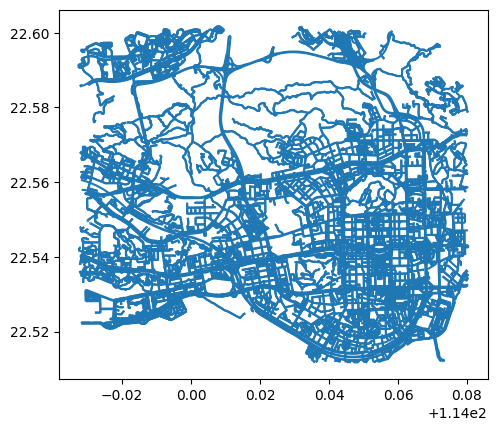

In [67]:
# 另一种定义union bound的方法：看所有轨迹的最小矩形围
# data_deliver_sonset = data_deliver[data_deliver['ID'].isin(res_list[m][n][2])]
# temp_bounds = [min(data_deliver_sonset["Lng"]),min(data_deliver_sonset["Lat"]),\
#     max(data_deliver_sonset["Lng"]),max(data_deliver_sonset["Lat"])]
# print(temp_bounds)
G,G_p,nodes,nodes_p,edges,edges_p =load_map(temp_bounds,padding)
plt.figure(figsize=(15, 5))
edges.plot()

# 将路网转换为网络
map_con = InMemMap(name='pNEUMA', use_latlon=False) # , use_rtree=True, index_edges=True)
# 构建网络
for node_id, row in nodes_p.iterrows():
    map_con.add_node(node_id, (row['y'], row['x']))
for node_id_1, node_id_2, _ in G_p.edges:
    map_con.add_edge(node_id_1, node_id_2)

# 可视化阶段 把路径在地图上画出来

载入数据 定义utils函数

In [68]:
# 参数配置
color_list = ['blue','red','darkgreen','purple',"peru","darkorange"]

# 绘制一条path或一条tra
# path代表需要绘制的路径，格式为edge构成的list
# edges和edges_p 代表底图路网，bounds代表观察窗口
def plot_tra(path,edges,edges_p,bounds,color='blue',ax = None,plt_show=None):
    if ax==None:
        fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(15,6))
        ax = tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = ax,color = '#333',lw = 0.1)
        # print("none")
    else:
        ax=ax
    
    for j in range(len(path)):
        plot_edge(edges_p,path[j]).plot(ax = ax,zorder = 1,color = color,alpha = 0.8)
    if plt_show:
        plt.show()
    return ax
# plot_tra(tra_edge_list_load[loc2],edges,edges_p,bounds,color='blue',ax = None,plt_show=None)

# 输入r矩阵和哪一列，输出用到的path的list  (从path_list中把使用到的挑出来 是无序的)
def get_path_list_usedtorec(r_tensor,col_index,path_list):
    temp_path_list = []#记录表达该轨迹所用到的path
    R_col = r_tensor[:,col_index]
    for i in range(len(R_col)):
        if R_col[i]==1:
            temp_path_list.append(path_list[i])
    return temp_path_list


In [69]:
# 加载保存好的地图匹配的结果继续可视化 这里有点关注p of p 问题 所以在代码设计中考虑了同时考虑了兼容两个网格和合并网格的结果
# 查看没有使用pathlet抽取算法之前，原始的分割数据是什么样子的，发现中间有断开的情况，可能会影响后续计算
import pandas as pd
all_tra_id_list_load = []
all_tra_edge_list_load = []
tra_id_list_load=np.load(dataset_dir+'new_dataset/tra_id_listfutian5533.npy',allow_pickle=True).tolist()
tra_edge_list_load=np.load(dataset_dir+'new_dataset/tra_datasetfutian5_5_5533.npy',allow_pickle=True).tolist()
all_tra_id_list_load.append(tra_id_list_load)
all_tra_edge_list_load.append(tra_edge_list_load)

先画一下轨迹映射后的结果（也就是最原始的gps序列和轨迹）

In [70]:
import matplotlib.colors as mcolors
color_list = list(mcolors.TABLEAU_COLORS.values())
print(color_list)# 0 1 3 5 4 6 7

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [71]:
# fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(25,12))
# ax = tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = ax,color = '#333',lw = 0.1)    
# for j in range(0,20):
#     plot_edge(edges_p,path[j]).plot(ax = ax,zorder = 1,linewidth=4,color = color_list[7],alpha = 1)
# plt.show()
# fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(25,12))
# ax = tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = ax,color = '#333',lw = 0.1)    
# for j in range(20,len(path)):
#     plot_edge(edges_p,path[j]).plot(ax = ax,zorder = 1,linewidth=4,color = color_list[4],alpha = 1)
# plt.show()

# fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(25,12))
# ax = tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = ax,color = '#333',lw = 0.1)    
# for j in range(0,len(path)):
#     plot_edge(edges_p,path[j]).plot(ax = ax,zorder = 1,linewidth=4,color = color_list[6],alpha = 1)
# plt.show()

In [72]:
# # 这个cell只是用来绘制一个grid里边的所有轨迹
# tra_dataset = all_tra_edge_list_load[0]
# # fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(15,6))
# # ax = tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = ax,color = '#333',lw = 0.1)
# for tra_index in range(34,35):
#     print(tra_index)
#     fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(15,6))
#     ax = tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = ax,color = '#333',lw = 0.1)
#     path = tra_dataset[tra_index]
#     for j in range(len(path)):
#         plot_edge(edges_p,path[j]).plot(ax = ax,zorder = 1,color = color_list[tra_index%len(color_list)],alpha = 1)
#     plt.show()
# #     # # ax.set_xlim(116.33, 116.35)
# #     # # ax.set_ylim(39.97, 40.02)
# # temp_bounds


In [73]:
# # 这里主要是在关注high-level的 一个轨迹被分开成两半的情况 依次在多张图上打印多条轨迹
# # for i in range(temp_tra_id,temp_tra_id+1):
# for loc_index in range(10,50):
#     # loc_index =2
#     loc1,loc2 = loc12_list[loc_index][1],loc12_list[loc_index][2]
#     print(loc_index)  
#     fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(10,6))
#     edges_p['lon'] = edges_p.centroid.x
#     edges_p['lat'] = edges_p.centroid.y
#     tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = axes,color = '#333',lw = 0.1)
#     for j in range(len(all_tra_edge_list_load[1][loc1])):
#         plot_edge(edges_p,all_tra_edge_list_load[1][loc1][j]).plot(ax = axes,zorder = 1,color = color_list[0],alpha = 0.5)
#     for j in range(len(all_tra_edge_list_load[2][loc2])):
#         plot_edge(edges_p,all_tra_edge_list_load[2][loc2][j]).plot(ax = axes,zorder = 1,color = color_list[1],alpha = 0.5)
#     plt.show()

加载path重构结果

In [110]:

import torch
#加载path_list和R_tensor 来自服务器
all_path_edge_list_load=[]
all_R_tensor_rounded=[]
r_tensor_dir = dataset_dir+"from_server/"


# shenzhen futian distinct
# all_path_edge_list_load.append([])
# all_R_tensor_rounded.append(0)

# --------------------------------------
# path_edge_list_loadp2=np.load(r_tensor_dir+'path_listtra_datasetfutian5_4_5436.npy',allow_pickle=True).tolist()
# R_tensor_roundedp2 = torch.load(r_tensor_dir+'R_tensor_rounded_futian5_4_.pt',map_location=torch.device('cpu'))
# all_path_edge_list_load.append(path_edge_list_loadp2)
# all_R_tensor_rounded.append(R_tensor_roundedp2)

path_edge_list_loadp2=np.load(r_tensor_dir+'path_listtra_datasetfutian5_5_5533.npy',allow_pickle=True).tolist()
R_tensor_roundedp2 = torch.load(r_tensor_dir+'R_tensor_rounded_tra_datasetfutian5_5_5533[100,_10,_0,_0]0_.pt',map_location=torch.device('cpu'))
all_path_edge_list_load.append(path_edge_list_loadp2)
all_R_tensor_rounded.append(R_tensor_roundedp2)

# path_edge_list_loadp2=np.load(r_tensor_dir+'path_listtra_datasetfutian6_4_4843.npy',allow_pickle=True).tolist()
# R_tensor_roundedp2 = torch.load(r_tensor_dir+'R_tensor_rounded_tra_datasetfutian6_4_4843[100,_10,_0,_0]0_.pt',map_location=torch.device('cpu'))
# all_path_edge_list_load.append(path_edge_list_loadp2)
# all_R_tensor_rounded.append(R_tensor_roundedp2)

# path_edge_list_loadp2=np.load(r_tensor_dir+'path_listtra_datasetfutian6_4_4843.npy',allow_pickle=True).tolist()
# R_tensor_roundedp2 = torch.load(r_tensor_dir+'R_tensor_rounded_tra_datasetfutian6_4_4843[100,_10,_0,_0]0_.pt',map_location=torch.device('cpu'))
# all_path_edge_list_load.append(path_edge_list_loadp2)
# all_R_tensor_rounded.append(R_tensor_roundedp2)

# path_edge_list_loadp2=np.load(r_tensor_dir+'path_listtra_dataset_futian_p2_31402.npy',allow_pickle=True).tolist()
# R_tensor_roundedp2 = torch.load(r_tensor_dir+'R_tensor_rounded_tra_dataset_futian_p2_31402[100, 10, 0, 0]0_.pt',map_location=torch.device('cpu'))
# all_path_edge_list_load.append(path_edge_list_loadp2)
# all_R_tensor_rounded.append(R_tensor_roundedp2)


# --------------------------------------



# path_edge_list_loadp2=np.load(r_tensor_dir+'path_listtra_datasetfutian4_4_18189shrink.npy',allow_pickle=True).tolist()
# R_tensor_roundedp2 = torch.load(r_tensor_dir+'R_tensor_rounded_tra_datasetfutian4_4_18189shrink[100,_10,_0,_0]0_.pt',map_location=torch.device('cpu'))
# all_path_edge_list_load.append(path_edge_list_loadp2)
# all_R_tensor_rounded.append(R_tensor_roundedp2)


# path_edge_list_load=np.load(r_tensor_dir+'path_listtra_dataset_futian4_4_21579.npy',allow_pickle=True).tolist()
# R_tensor_rounded = torch.load(r_tensor_dir+'R_tensor_rounded_tra_dataset_futian4_4_21579[100, 10, 0, 0]0_.pt',map_location=torch.device('cpu'))
# all_path_edge_list_load.append(path_edge_list_load)
# all_R_tensor_rounded.append(R_tensor_rounded)

# path_edge_list_load=np.load(r_tensor_dir+'path_listtra_dataset_futian4_5_9456.npy',allow_pickle=True).tolist()
# R_tensor_rounded = torch.load(r_tensor_dir+'R_tensor_rounded_tra_dataset_futian4_5_9456[100, 10, 0, 0]0_.pt',map_location=torch.device('cpu'))
# all_path_edge_list_load.append(path_edge_list_load)
# all_R_tensor_rounded.append(R_tensor_rounded)

# path_edge_list_load=np.load(r_tensor_dir+'path_listtra_dataset_futian4_6_440.npy',allow_pickle=True).tolist()
# R_tensor_rounded = torch.load(r_tensor_dir+'R_tensor_rounded_tra_dataset_futian4_6_440[100, 10, 0, 0]0_.pt',map_location=torch.device('cpu'))
# all_path_edge_list_load.append(path_edge_list_load)
# all_R_tensor_rounded.append(R_tensor_rounded)

# path_edge_list_load=np.load(r_tensor_dir+'path_listtra_dataset_futian5_4_56958.npy',allow_pickle=True).tolist()
# R_tensor_rounded = torch.load(r_tensor_dir+'R_tensor_rounded_tra_dataset_futian5_4_56958[100, 10, 0, 0]0_.pt',map_location=torch.device('cpu'))
# all_path_edge_list_load.append(path_edge_list_load)
# all_R_tensor_rounded.append(R_tensor_rounded)

# path_edge_list_load=np.load(r_tensor_dir+'path_listtra_dataset_futian5_5_17530.npy',allow_pickle=True).tolist()
# R_tensor_rounded = torch.load(r_tensor_dir+'R_tensor_rounded_tra_dataset_futian5_5_17530[100, 10, 0, 0]0_.pt',map_location=torch.device('cpu'))
# all_path_edge_list_load.append(path_edge_list_load)
# all_R_tensor_rounded.append(R_tensor_rounded)

# path_edge_list_load=np.load(r_tensor_dir+'path_listtra_dataset_futian5_6_1475.npy',allow_pickle=True).tolist()
# R_tensor_rounded = torch.load(r_tensor_dir+'R_tensor_rounded_tra_dataset_futian5_6_1475[100, 10, 0, 0]0_.pt',map_location=torch.device('cpu'))
# all_path_edge_list_load.append(path_edge_list_load)
# all_R_tensor_rounded.append(R_tensor_rounded)


# path_edge_list_loadp2=np.load(r_tensor_dir+'path_listtra_dataset_futian_p2_31402.npy',allow_pickle=True).tolist()
# R_tensor_roundedp2 = torch.load(r_tensor_dir+'R_tensor_rounded_tra_dataset_futian_p2_31402[100, 10, 0, 0]0_.pt',map_location=torch.device('cpu'))
# all_path_edge_list_load.append(path_edge_list_loadp2)
# all_R_tensor_rounded.append(R_tensor_roundedp2)

# path_edge_list_loadp2=np.load(r_tensor_dir+'path_listtra_dataset_nanshan3_6_2385.npy',allow_pickle=True).tolist()
# R_tensor_roundedp2 = torch.load(r_tensor_dir+'R_tensor_rounded_tra_dataset_nanshan3_6_2385[100, 10, 0, 0].pt',map_location=torch.device('cpu'))

In [75]:
R_tensor_roundedp2.shape

torch.Size([15071, 15000, 1])

把高频的pathlet挑出来 并可视化

In [114]:
R_tensor_rounding.size()

torch.Size([17062, 5138, 1])

In [111]:
# 根据r_tensor，把高频的pathlet挑出来
pathlet_dictionary_list = []
for j in range(0,1):

# j=0
    path_list =all_path_edge_list_load[j]
    R_tensor_rounding = all_R_tensor_rounded[j]
    path_list_len = len(path_list)
    path_list_cnt = np.zeros((path_list_len+10,3))
    R_size = R_tensor_rounding.size()
    pathlet_cnt = torch.sum(R_tensor_rounding, dim=1).cpu().numpy().round(1)
    for i in trange(R_size[0]):
        path_list_cnt[i][0]=i
        path_list_cnt[i][1]=pathlet_cnt[i]
        if i <path_list_len:
            path_list_cnt[i][2]=len(path_list[i])
    path_list_cnt_df = pd.DataFrame(path_list_cnt,columns=["index","cnt",'len'])
    pathlet_dictionary = path_list_cnt_df[path_list_cnt_df["cnt"]>1].sort_values(by=['len'],ascending = False)
    pathlet_dictionary_list.append(pathlet_dictionary)
# pathlet_dictionary
# pathlet_dictionary.sort_values("cnt",ascending=False)

100%|██████████| 17062/17062 [00:00<00:00, 1003705.73it/s]


In [77]:
# i=0
# path_list =all_path_edge_list_load[i]
# R_tensor_rounding = all_R_tensor_rounded[i]
# path_list_len = len(path_list)
# path_list_cnt = np.zeros((path_list_len+10,3))
# R_size = R_tensor_rounding.size()
# pathlet_cnt = torch.sum(R_tensor_rounding, dim=1).cpu().numpy().round(1)
# for i in trange(R_size[0]):
#     path_list_cnt[i][0]=i
#     path_list_cnt[i][1]=pathlet_cnt[i]
#     if i <path_list_len:
#         path_list_cnt[i][2]=len(path_list[i])
# path_list_cnt_df = pd.DataFrame(path_list_cnt,columns=["index","cnt",'len'])
# pathlet_dictionary = path_list_cnt_df[path_list_cnt_df["cnt"]>0].sort_values(by=['cnt'],ascending = False)
# color_list = ['blue','pink','red','yellow','green','red']


In [78]:
# strpath2rawpath(all_path_edge_list_load[j][1033])

In [112]:
def strpath2rawpath_p2_version(strpath):
    local_strpath = strpath.replace("[","")
    local_strpath = local_strpath.replace("]","")
    local_strpath = local_strpath.replace("(","")
    local_strpath = local_strpath.replace(")","")
    node_list = local_strpath.split(",")
    res = []
    for i in range(0,len(node_list)-1):
        res.append((int(node_list[i]),int(node_list[i+1])))
    return res

# strpath2rawpath_p2_version(all_path_edge_list_load[j][11569])

In [92]:
# 画出dictionary中排名靠前的x条pathlets
j=0
# for i in trange(0,1000):
#     if i==0:
#         axes = plot_tra(strpath2rawpath(all_path_edge_list_load[j][int(list(pathlet_dictionary_list[j]["index"])[i])]),edges,edges_p,bounds,color='blue',ax = None,plt_show=1)
#     else:
#         if (list(pathlet_dictionary_list[j]["cnt"])[i]>8):
#             print(i,list(pathlet_dictionary_list[j]["cnt"])[i],list(pathlet_dictionary_list[j]["index"])[i])
#             plot_tra(strpath2rawpath(all_path_edge_list_load[j][int(list(pathlet_dictionary_list[j]["index"])[i])]),edges,edges_p,bounds,color=color_list[i%6],ax = axes,plt_show=1)


pathlet_dictionary_top = pathlet_dictionary[(pathlet_dictionary["cnt"]>1) & (pathlet_dictionary["len"]>500) & (pathlet_dictionary["len"]<900)].sort_values("cnt",ascending=False)
# good_pathlet_list = [4,5,11,16,19,20,26,32,37,]#futian p2

# pathlet_dictionary_top = pathlet_dictionary[(pathlet_dictionary["cnt"]>5) & (pathlet_dictionary["len"]>100) & (pathlet_dictionary["len"]<600)].sort_values("cnt",ascending=False)
# # good_pathlet_list = [0,9,12,17,20,22,24,29,31,35,43,48,52,53,54,73,75,77,79,82,87,89,34]#futian p2

# pathlet_dictionary_top = pathlet_dictionary[(pathlet_dictionary["cnt"]>5) & (pathlet_dictionary["len"]>900) & (pathlet_dictionary["len"]<5000)].sort_values("len",ascending=False)
# good_pathlet_list = [16,17,22,]

# 画出dictionary中排名靠前的x条pathlets
# fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,8))
# ax = tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = ax,color = '#333',lw = 0.2)
bad_pathlet_list = [ 0,13,18]
# good_pathlet_list = [ 3,6,15,21,24,35,47,61,67,80,93]#5-5
# good_pathlet_list = [45,50,54,55,57,62,25,24,23,21,11,10]#4-4
for i in trange(0,100):
    if i  in good_pathlet_list:
    # if 1:
    # if i not in bad_pathlet_list:
        path_id = int(list(pathlet_dictionary_top["index"])[i])
        path = strpath2rawpath(all_path_edge_list_load[0][path_id])
        fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,12))
        ax = tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = ax,color = '#333',lw = 0.15)
        for j in range(len(path)):
            plot_edge(edges_p,path[j]).plot(ax = ax,zorder = 1.5, linewidth=4.5,color = color_list[i%len(color_list)+1],alpha = 1)
        plt.show()




'[(9906899089,9906911255,9906911269,9906911268,9906911283,9906911275,9906912250,8986992863),(9906899089,9906911255,9906911269,9906911268,9906911283,9906911275,9906912250,8986992863,8986992870),(9906899089,9906911255,9906911269,9906911268,9906911283,9906911275,9906912250,8986992863,1342322923)]'

  0%|          | 0/100 [00:00<?, ?it/s]

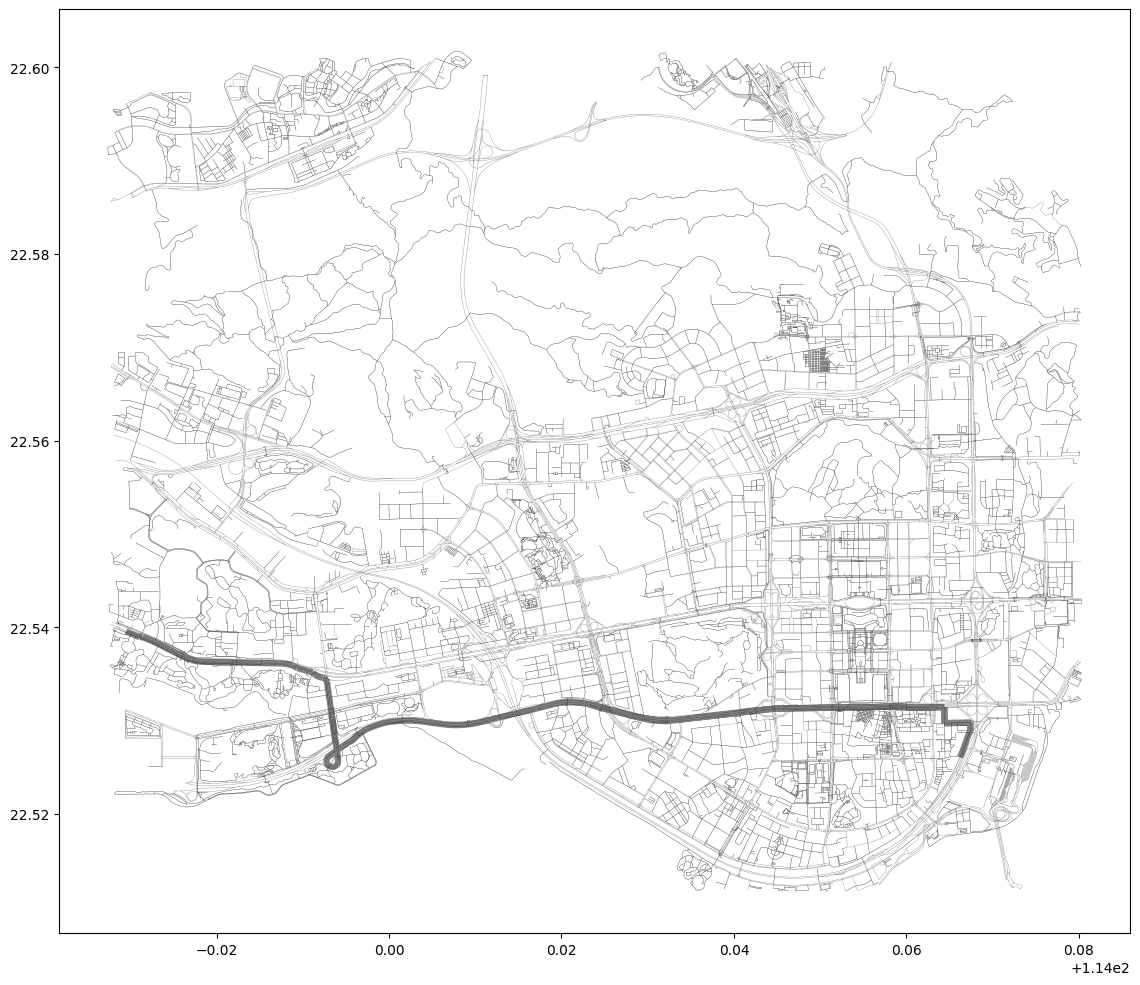

 17%|█▋        | 17/100 [00:14<01:09,  1.19it/s]

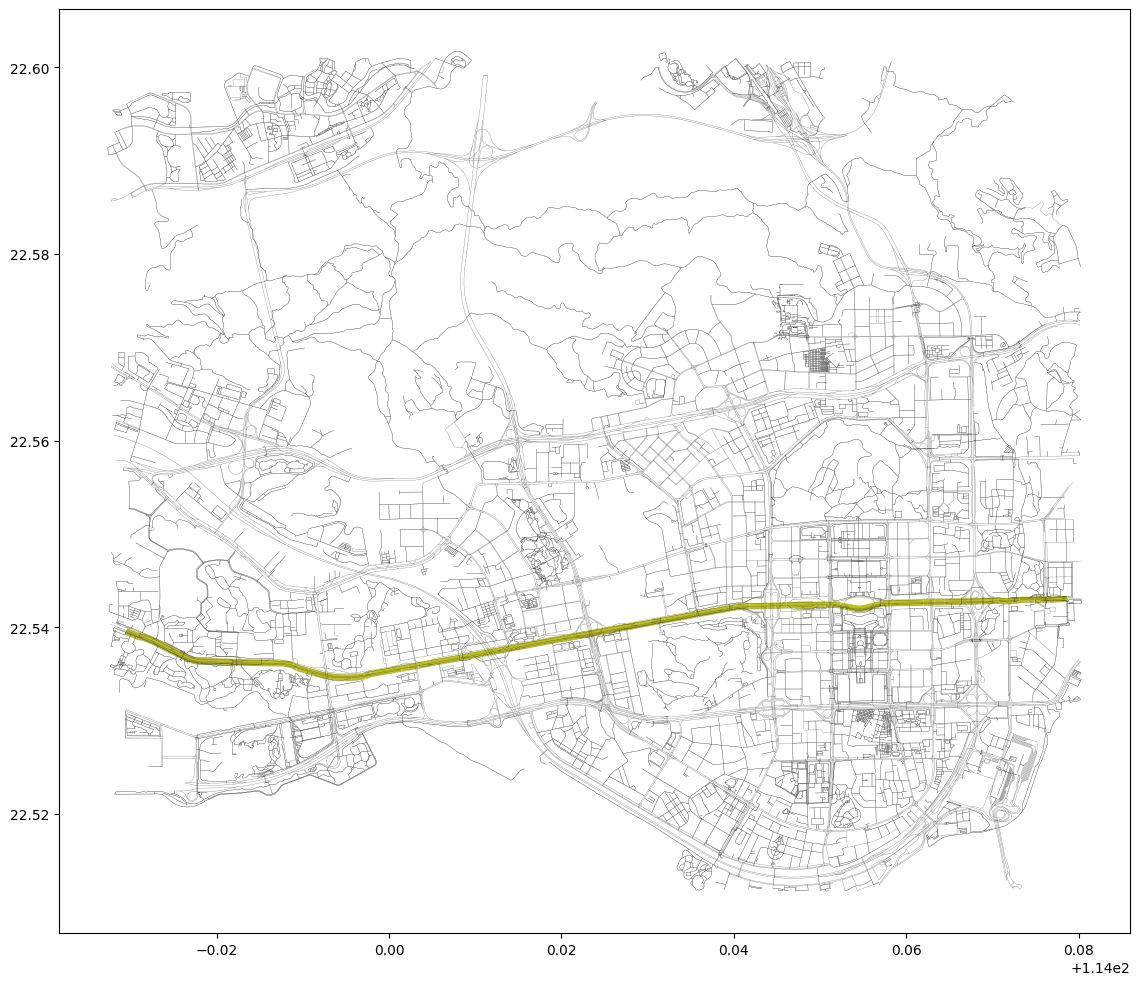

 18%|█▊        | 18/100 [00:27<02:28,  1.81s/it]

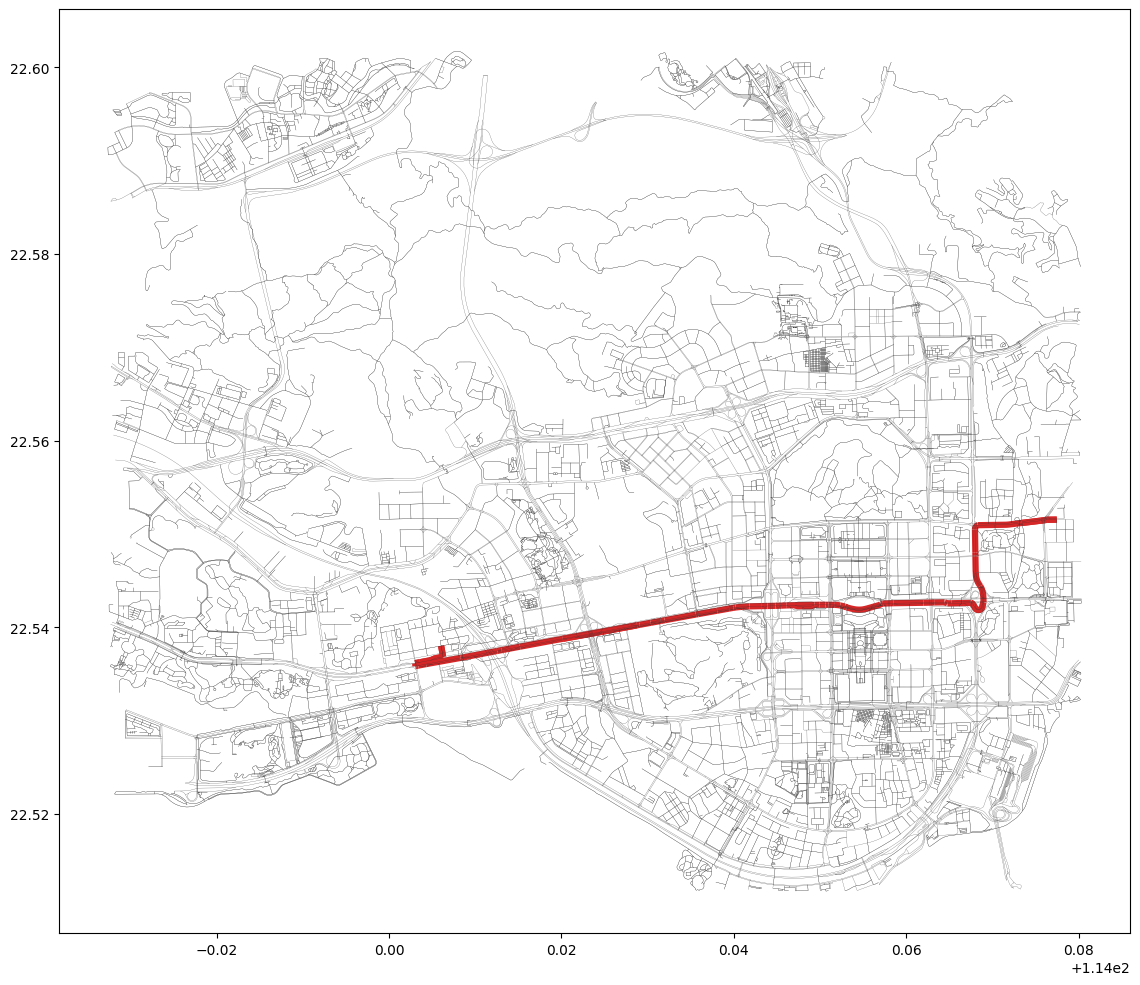

100%|██████████| 100/100 [00:40<00:00,  2.49it/s]


In [109]:
# 画出dictionary中排名靠前的x条pathlets
j=0
# for i in trange(0,1000):
#     if i==0:
#         axes = plot_tra(strpath2rawpath(all_path_edge_list_load[j][int(list(pathlet_dictionary_list[j]["index"])[i])]),edges,edges_p,bounds,color='blue',ax = None,plt_show=1)
#     else:
#         if (list(pathlet_dictionary_list[j]["cnt"])[i]>8):
#             print(i,list(pathlet_dictionary_list[j]["cnt"])[i],list(pathlet_dictionary_list[j]["index"])[i])
#             plot_tra(strpath2rawpath(all_path_edge_list_load[j][int(list(pathlet_dictionary_list[j]["index"])[i])]),edges,edges_p,bounds,color=color_list[i%6],ax = axes,plt_show=1)


# pathlet_dictionary_top = pathlet_dictionary[(pathlet_dictionary["cnt"]>1) & (pathlet_dictionary["len"]>500) & (pathlet_dictionary["len"]<900)].sort_values("cnt",ascending=False)
# good_pathlet_list = [4,5,11,16,19,20,26,32,37,]#futian p2

pathlet_dictionary_top = pathlet_dictionary[(pathlet_dictionary["cnt"]>5) & (pathlet_dictionary["len"]>100) & (pathlet_dictionary["len"]<600)].sort_values("cnt",ascending=False)
# good_pathlet_list = [0,9,12,17,20,22,24,29,31,35,43,48,52,53,54,73,75,77,79,82,87,89,34]#futian p2

pathlet_dictionary_top = pathlet_dictionary[(pathlet_dictionary["cnt"]>5) & (pathlet_dictionary["len"]>900) & (pathlet_dictionary["len"]<5000)].sort_values("len",ascending=False)
good_pathlet_list = [16,17,22,]

# 画出dictionary中排名靠前的x条pathlets
# fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(14,8))
# ax = tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = ax,color = '#333',lw = 0.2)
bad_pathlet_list = [ 0,13,18]
# good_pathlet_list = [ 3,6,15,21,24,35,47,61,67,80,93]#5-5
# good_pathlet_list = [45,50,54,55,57,62,25,24,23,21,11,10]#4-4
for i in trange(0,100):
    if i  in good_pathlet_list:
    # if 1:
    # if i not in bad_pathlet_list:
        path_id = int(list(pathlet_dictionary_top["index"])[i])
        path = strpath2rawpath_p2_version(all_path_edge_list_load[0][path_id])
        fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(18,12))
        ax = tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = ax,color = '#333',lw = 0.15)
        for j in range(len(path)):
            plot_edge(edges_p,path[j]).plot(ax = ax,zorder = 1.5, linewidth=4.5,color = color_list[i%len(color_list)+1],alpha = 1)
        plt.show()




In [97]:
pathlet_dictionary_top

,index,cnt,len


In [29]:
# # 画出dictionary中排名靠前的x条pathlets
# j=3
# for i in range(10):
#     if i==0:
#         axes = plot_tra(strpath2rawpath(all_path_edge_list_load[j][int(list(pathlet_dictionary_list[j]["index"])[i])]),edges,edges_p,bounds,color='blue',ax = None,plt_show=None)
#     else:
#         plot_tra(strpath2rawpath(all_path_edge_list_load[j][int(list(pathlet_dictionary_list[j]["index"])[i])]),edges,edges_p,bounds,color=color_list[i%6],ax = axes,plt_show=None)


case study  查看轨迹重构结果

In [ ]:
# 绘制一条轨迹以及它的重构结果
region_id=0
# loc1 = all_tra_id_list_load[region_id].index(11378)
# loc1 = all_tra_id_list_load[region_id].index(16549)
# loc1 = all_tra_id_list_load[region_id].index(5)
# loc1 = all_tra_id_list_load[region_id].index(25313)
# loc1=40
for loc1 in range(10):

    tra = all_tra_edge_list_load[region_id][loc1]

    fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(15,6))
    tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = axes[0],color = '#333',lw = 0.1)
    tbd.clean_outofbounds(edges,bounds,col = ['lon','lat']).plot(ax = axes[1],color = '#333',lw = 0.1)
    # 绘制这条tra的重构结果
    plot_tra(tra,edges,edges_p,bounds,color='blue',ax = axes[0],plt_show=None)

    # 绘制这条tra的重构结果

    unorder_path_list = get_path_list_usedtorec(all_R_tensor_rounded[region_id],loc1,all_path_edge_list_load[region_id])
    print(loc1,len(unorder_path_list))
    for i in range(len(unorder_path_list)):
        path = strpath2rawpath(unorder_path_list[i])
        for j in range(len(path)):
            plot_edge(edges_p,path[j]).plot(ax = axes[1],zorder = 1,color = color_list[i%len(color_list)],alpha = 0.85)
            # plot_edge(edges_p,path[j]).plot(ax = ax,zorder = 1,color = color_list[unorder_path_list.index(path)%2],alpha = 0.5)
    plt.show()



将local pathlet视为edge 构造新的轨迹数据集

In [ ]:
# 找到那些同时经过两个区域的common tra 根据low-level的pathlet结果学习高层次的pathlet
from tqdm import tqdm
res = []
tra_id_p2_list = []
# common_tra_list = list(set(all_tra_id_list_load[1]) & set(all_tra_id_list_load[2]))
# for region_id in [1,2]:
#     for ite_var in trange(len(all_tra_id_list_load[region_id])):
#         tra_index = all_tra_id_list_load[region_id][ite_var]
#         if tra_index not in common_tra_list:
#             unorder_path_list = get_path_list_usedtorec(all_R_tensor_rounded[region_id],ite_var,all_path_edge_list_load[region_id])

#             res.append(transform_tra_2_continue_paths(all_tra_edge_list_load[region_id][ite_var],unorder_path_list))
#             tra_id_p2_list.append(tra_index)
# for tra_real_index in common_tra_list:
# for (loc0,loc1,loc2) in loc12_list:
for loc_index in trange(len(tra_loc_in_regions_df)):
    if list(tra_loc_in_regions_df["appear_cnt"])[loc_index]>2:
        tra_id_p2_list.append(tra_loc_in_regions_df[0][loc_index])
        unorder_path_list = []
        for cloum_index in range(1,7):
            if tra_loc_in_regions_df.iloc[loc_index,cloum_index]!=-1 and tra_loc_in_regions_df.iloc[loc_index,cloum_index]<8000:
                unorder_path_list += get_path_list_usedtorec(all_R_tensor_rounded[cloum_index],\
                                                         tra_loc_in_regions_df.iloc[loc_index,cloum_index],all_path_edge_list_load[cloum_index])
    # unorder_path_list1 = get_path_list_usedtorec(all_R_tensor_rounded[1],loc1,all_path_edge_list_load[1])
    # unorder_path_list2 = get_path_list_usedtorec(all_R_tensor_rounded[2],loc2,all_path_edge_list_load[2])

        res.append(transform_tra_2_continue_paths(all_tra_edge_list_load[0][tra_loc_in_regions_df.iloc[loc_index,0]],unorder_path_list))
# tra_id_p2_list=tra_id_p2_list+common_tra_list
# 保存tra 以list of p的形式
np.save('tra_id_futian_p2_list.npy',np.array(tra_id_p2_list,dtype=object))   # 保存为.npy格式 
print("number of tras for matrix method:",len(res))
print("number of tras for matrix method:",len(tra_id_p2_list))
np.save('tra_dataset_futian_p2'+'_'+str(len(res))+'.npy',np.array(res,dtype=object))   # 保存为.npy格式 
    


In [ ]:
def transform_tra_2_continue_paths(tra,unorder_path_list):
    res = []
    temp_path_list=unorder_path_list#记录这个tra究竟用到了哪些path来进行重构，此时是无序的，res中则是排序之后的
    # for i in path_ids:
    #     temp_path_list.append(path_list[i])

    current_edge_index = 0
    while current_edge_index<len(tra):
        current_edge = str(tra[current_edge_index]).replace(" ","")
        for path in temp_path_list:
            if current_edge in path:
                res.append(transform_pathlet_2_continueedges(strpath2rawpath(path)))
                temp_path_list.remove(path)
                break
        current_edge_index+=1
                
    return res

In [ ]:
path_edge_list_loadp2[0]

In [ ]:
# 画出dictionary中排名靠前的x条pathlets
for i in range(1):
    if i==0:
        axes = plot_tra(strpath2rawpath(all_path_edge_list_load[0][int(list(pathlet_dictionary["index"])[i])]),edges,edges_p,bounds,color='blue',ax = None,plt_show=None)
    else:
        plot_tra(strpath2rawpath(all_path_edge_list_load[0][int(list(pathlet_dictionary["index"])[i])]),edges,edges_p,bounds,color=color_list[i%6],ax = axes,plt_show=None)


## 对比DP结果

In [ ]:
trajectory_dataset=np.load('C:/tyb_file/tyb_tasks/pathlet/datasets/tra_dataset_futian4_4_21579.npy',allow_pickle=True).tolist()[:8000]
# trajectory_dataset[0]
tra_dataset_remove_redunctency = []
for tra in trajectory_dataset:
    if tra not in tra_dataset_remove_redunctency:
        tra_dataset_remove_redunctency.append(tra)
print(len(tra_dataset_remove_redunctency))

In [ ]:
pathlet_dict_dp=np.load(dataset_dir+'/pathlet_dict.npy',allow_pickle=True).tolist()
pathlet_dict_dp

In [ ]:
pathlet_dictionary = []
num_of_used_pathlet = 0
num_of_unchange_tra = 0
for iter_i in trange(len(list(pathlet_dict_dp.keys()))):
    temp_pathlets = pathlet_dict_dp[list(pathlet_dict_dp.keys())[iter_i]]
    # print(type(temp_pathlets[0]))
    if type(temp_pathlets[0])==type([1,2]):#如果分开了
    # if 
        num_of_used_pathlet+=len(temp_pathlets)
        for temp_pathlet in temp_pathlets:
            if temp_pathlet not in pathlet_dictionary:
                pathlet_dictionary.append(temp_pathlet)
    else:#如果没有分开了
        num_of_used_pathlet+=1
        num_of_unchange_tra+=1
        if temp_pathlets not in pathlet_dictionary:
            pathlet_dictionary.append(temp_pathlet)

print(len(pathlet_dictionary))
print(num_of_used_pathlet)
print(num_of_unchange_tra)

# downstream task 计算轨迹距离的groundtruth

In [ ]:
import numpy as np
from scipy.spatial.distance import directed_hausdorff

# 输入GPS轨迹点数据，格式为：[(lat1, lon1), (lat2, lon2), ...]
gps_track_1 = [(39.903234, 116.391019), (39.903255, 116.392038), (39.903648, 116.392857)]
gps_track_2 = [(39.903234, 116.391019), (39.903255, 116.392038)]

# 转换为NumPy数组
track_1_np = np.array(gps_track_1)
track_2_np = np.array(gps_track_2)

# 计算Hausdorff距离
hausdorff_distance = max(directed_hausdorff(track_1_np, track_2_np)[0], directed_hausdorff(track_2_np, track_1_np)[0])

print("Hausdorff distance between GPS tracks:", hausdorff_distance)


In [ ]:
import math

def haversine_distance(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    R = 6371  # 地球半径，单位为千米

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)
    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    d = R * c

    return d
import math
def frechet_distance(traj1, traj2):
    m, n = len(traj1), len(traj2)
    if m == 0 or n == 0:
        raise ValueError("轨迹不能为空")

    # 初始化动态规划矩阵
    dp = [[None] * n for _ in range(m)]

    # 填充矩阵边界
    dp[0][0] = haversine_distance(traj1[0], traj2[0])
    for i in range(1, m):
        dp[i][0] = max(dp[i-1][0], haversine_distance(traj1[i], traj2[0]))
    for j in range(1, n):
        dp[0][j] = max(dp[0][j-1], haversine_distance(traj1[0], traj2[j]))

    # 填充矩阵剩余部分
    for i in range(1, m):
        for j in range(1, n):
            cost = haversine_distance(traj1[i], traj2[j])
            dp[i][j] = max(min(dp[i-1][j], dp[i][j-1], dp[i-1][j-1]), cost)

    return dp[-1][-1]
traj1 = [(39.905963, 116.391253), (39.906002, 116.391268), (39.906043, 116.391283)]
traj2 = [(39.905983, 116.391233), (39.906022, 116.391248), (39.906063, 116.391263)]

fd = frechet_distance(traj1, traj2)
print("Fréchet distance:", fd)



In [ ]:
tra_ids=np.load(dataset_dir+'/tra_id_list_futian4_4_21579.npy',allow_pickle=True).tolist()
len(tra_ids)
tra_ids = tra_ids[0:8000]

In [ ]:
def gdf2gps_seq(gdf):
    res=[]
    for i in range(len(gdf)):
        res.append((tmp_gdf.iloc[i,2],tmp_gdf.iloc[i,3]))
    return res
union_bounds = (res_list[4][4][0])
tra_ids = tra_ids#[0:8000]
# print("len(tra_id):",len(tra_id))
all_tras_seq = []
for i in  tqdm(tra_ids):

# if 1:

 
    # 使用一个矩形框 选中一个轨迹在矩形内的点
    tmp_gdf = data_deliver[data_deliver['ID'] == i].sort_values(by = 'Time')
    
    tmp_gdf = tmp_gdf[tmp_gdf["Lng"]>union_bounds[0]]
    tmp_gdf = tmp_gdf[tmp_gdf["Lng"]<union_bounds[2]]
    tmp_gdf = tmp_gdf[tmp_gdf["Lat"]>union_bounds[1]]
    tmp_gdf = tmp_gdf[tmp_gdf["Lat"]<union_bounds[3]]
    all_tras_seq.append(gdf2gps_seq(tmp_gdf))
    # tmp_gdf.plot()
# tmp_gdf

In [ ]:
frechet_distance(all_tras_seq[0], all_tras_seq[1])

In [ ]:
frechet_distance(all_tras_seq[0], all_tras_seq[0])

In [ ]:
dis_matrix_frechet = np.zeros((len(all_tras_seq),len(all_tras_seq)))
dis_matrix_hausdorff = np.zeros((len(all_tras_seq),len(all_tras_seq)))
for i in trange(len(all_tras_seq)-1000):
    for j in range(len(all_tras_seq)-1000):
        dis_matrix_frechet[i,j]=frechet_distance(all_tras_seq[i], all_tras_seq[j])
        dis_matrix_hausdorff[i,j] = max(directed_hausdorff(all_tras_seq[i], all_tras_seq[j])[0], directed_hausdorff(all_tras_seq[j], all_tras_seq[i])[0])


In [ ]:
np.save('dis_matrix_frechet.npy', dis_matrix_frechet)
np.save('dis_matburix_hausdorff.npy', dis_matrix_hausdorff)

In [ ]:
np.save("./tra_index_filtered_list.npy",np.array(tra_index_filtered_list,dtype=object))

In [ ]:
# 

traj_list=[]
for tra_index in tra_index_filtered_list[:]:
    tmp_gps_points = data_deliver[data_deliver["ID"]==all_tra_id_list_load[0][tra_index]][["Lng","Lat"]]
    tmp_gps_points = tmp_gps_points[tmp_gps_points["Lng"]>union_bounds[0]]
    tmp_gps_points = tmp_gps_points[tmp_gps_points["Lng"]<union_bounds[2]]
    tmp_gps_points = tmp_gps_points[tmp_gps_points["Lat"]>union_bounds[1]]
    tmp_gps_points = tmp_gps_points[tmp_gps_points["Lat"]<union_bounds[3]]
    traj_list.append(np.array(tmp_gps_points))
import numpy as np
# np.array(tra[["Lng","Lat"]])
import traj_dist.distance as tdist
import numpy as np
import traj_dist.distance as tdist
import pickle



In [ ]:


cdist3 = tdist.cdist(traj_list, traj_list, metric="discret_frechet")
np.save('dis_discret_frechet.npy',cdist3)
print("sspd")
cdist = tdist.cdist(traj_list, traj_list, metric="dtw")
np.save('dis_dtw.npy',cdist)
print("sspd")
cdist = tdist.cdist(traj_list, traj_list, metric="lcss")
np.save('dis_lcss.npy',cdist)
print("sspd")
cdist = tdist.cdist(traj_list, traj_list, metric="edr")
np.save('dis_edr.npy',cdist)
print("sspd")
cdist = tdist.cdist(traj_list, traj_list, metric="hausdorff")
np.save('dis_hausdorff.npy',cdist)
print("sspd")




In [ ]:
cdist = tdist.cdist(traj_list, traj_list, metric="sspd")
np.save('dis_sspd.npy',cdist)
print("sspd")